In [1]:
cd /home/tvangraft/tudelft/thesis/metaengineering

/home/tvangraft/tudelft/thesis/metaengineering


In [2]:
from src.pipeline.dataloader import DataLoader, DataLoaderConfig
from src.pipeline.frame.filter import FrameFilters
from src.pipeline.frame.transformer import FrameTransformers
from src.pipeline.taskloader import TaskLoader, TaskFrame, TaskLoaderConfig
from src.pipeline.trainer import Trainer

from src.utils.parsers.cv_parser import to_cv_params, parse_cv_result, fmt_cv_results, _fmt_regressor
from src.utils.utils import TestResultStore
from src.utils.visualizers.prediction_figures import PredictionFigures
from src.utils.visualizers.test_figures import TestFigures
from src.utils.visualizers.cv_figures import CVFigures

from src.settings.strategy import Strategy
from src.settings.tier import Tier

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
DataLoader.DATA_FOLDER = './data/training/'
dl: DataLoader = DataLoader()
tl: TaskLoader = TaskLoader()

In [4]:
def get_dataset(
    strategy:Strategy=Strategy.METABOLITE_CENTRIC,
    tier=Tier.TIER1,
    data_config: DataLoaderConfig = DataLoaderConfig(),
    task_config: TaskLoaderConfig = TaskLoaderConfig()
):
    df = dl.get_dataframe(data_config)
    gen = tl.prepare_task(df, tier).build(strategy, task_config)
    tf: TaskFrame = next(gen)
    return tf
    

config = DataLoaderConfig(
    additional_filters=[dl.data_factory.filters.is_precursor],
    additional_transforms=[dl.data_factory.transformer.log_fold_change_protein]
)

precursor_dataset = get_dataset(
    strategy=Strategy.ALL,
    tier=Tier.TIER0,
    data_config=config
)

precursor_dataset_raw = get_dataset(
    strategy=Strategy.ALL,
    tier=Tier.TIER0,
    data_config=DataLoaderConfig(
        additional_filters=[dl.data_factory.filters.is_precursor]
    )
)

In [14]:
import random

enzymes = precursor_dataset.x.index.get_level_values(0).unique().to_list()

for i in range(15):
    r = random.sample(
        population=enzymes,
        k=len(enzymes)
    )
    assert(len(r) == len(set(r)))
    print("\n")
    for e in r:
        print(e)
    



SyntaxError: f-string: empty expression not allowed (452287183.py, line 11)

In [ ]:
for m in precursor_dataset.x.index.get_level_values(0).unique().to_list():
    print(m)

# Visualizations
1. How many measures do I have per metabolite
2. What are the range for each precursor metabolite
3. For pyr, pep, dhap what are the knockouts that tricker the highest change

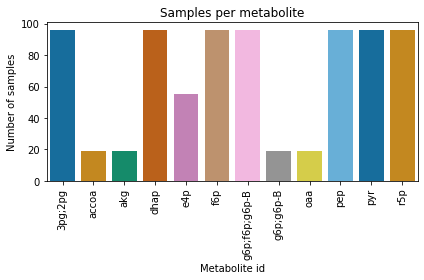

In [5]:
g = sns.countplot(
    data=precursor_dataset_raw.x.reset_index(),
    x='metabolite_id',
    palette='colorblind',
    dodge=False
)

g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=90)
g.set(xlabel="Metabolite id", ylabel="Number of samples", title="Samples per metabolite")
plt.tight_layout()

plt.savefig('./images/explorative/count_per_precursor_metabolite.svg')
plt.savefig('./images/explorative/count_per_precursor_metabolite.png')

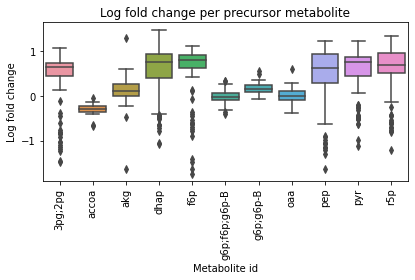

In [6]:
g = sns.boxplot(
    data=precursor_dataset.y.reset_index(),
    x='metabolite_id',
    y='metabolite_concentration'
)

g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=90)
g.set(xlabel="Metabolite id", ylabel="Log fold change", title="Log fold change per precursor metabolite")
plt.tight_layout()

plt.savefig('./images/explorative/boxplot_per_precursor_metabolite.svg')
plt.savefig('./images/explorative/boxplot_per_precursor_metabolite.png')

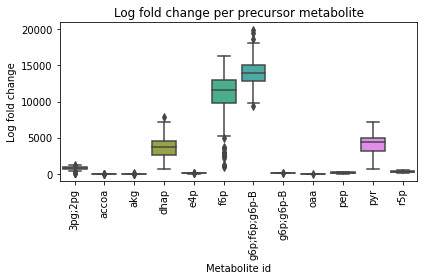

In [7]:
g = sns.boxplot(
    data=precursor_dataset_raw.y.reset_index(),
    x='metabolite_id',
    y='metabolite_concentration'
)

g.axes.set_xticklabels(g.axes.get_xticklabels(), rotation=90)
g.set(xlabel="Metabolite id", ylabel="Log fold change", title="Log fold change per precursor metabolite")
plt.tight_layout()

<AxesSubplot:xlabel='metabolite_concentration', ylabel='Density'>

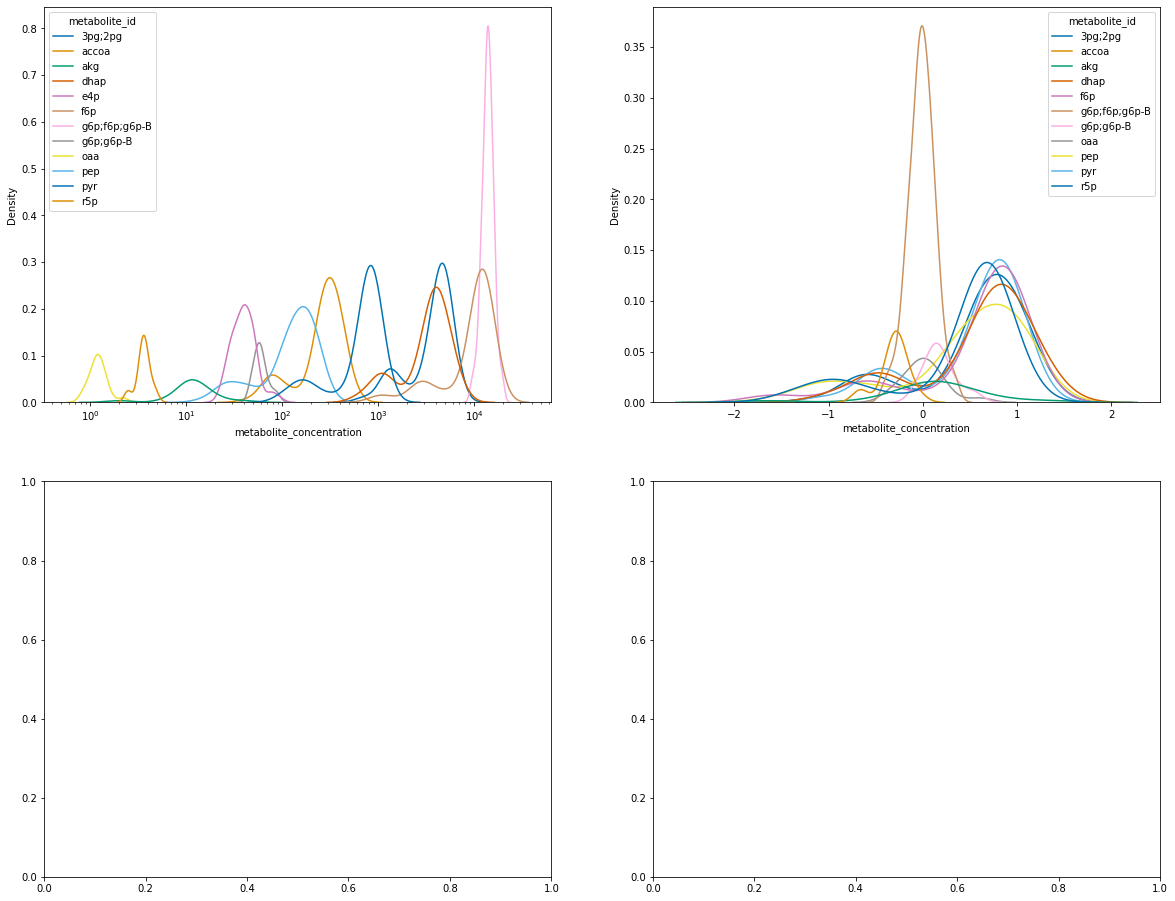

In [8]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(20, 16))

sns.kdeplot(
    data=precursor_dataset_raw.y.reset_index(),
    x='metabolite_concentration',
    hue='metabolite_id',
    log_scale=(True),
    fill=False,
    ax=ax1,
    palette='colorblind',
)

sns.kdeplot(
    data=precursor_dataset.y.reset_index(),
    x='metabolite_concentration',
    hue='metabolite_id',
    fill=False,
    ax=ax2,
    palette='colorblind',
)

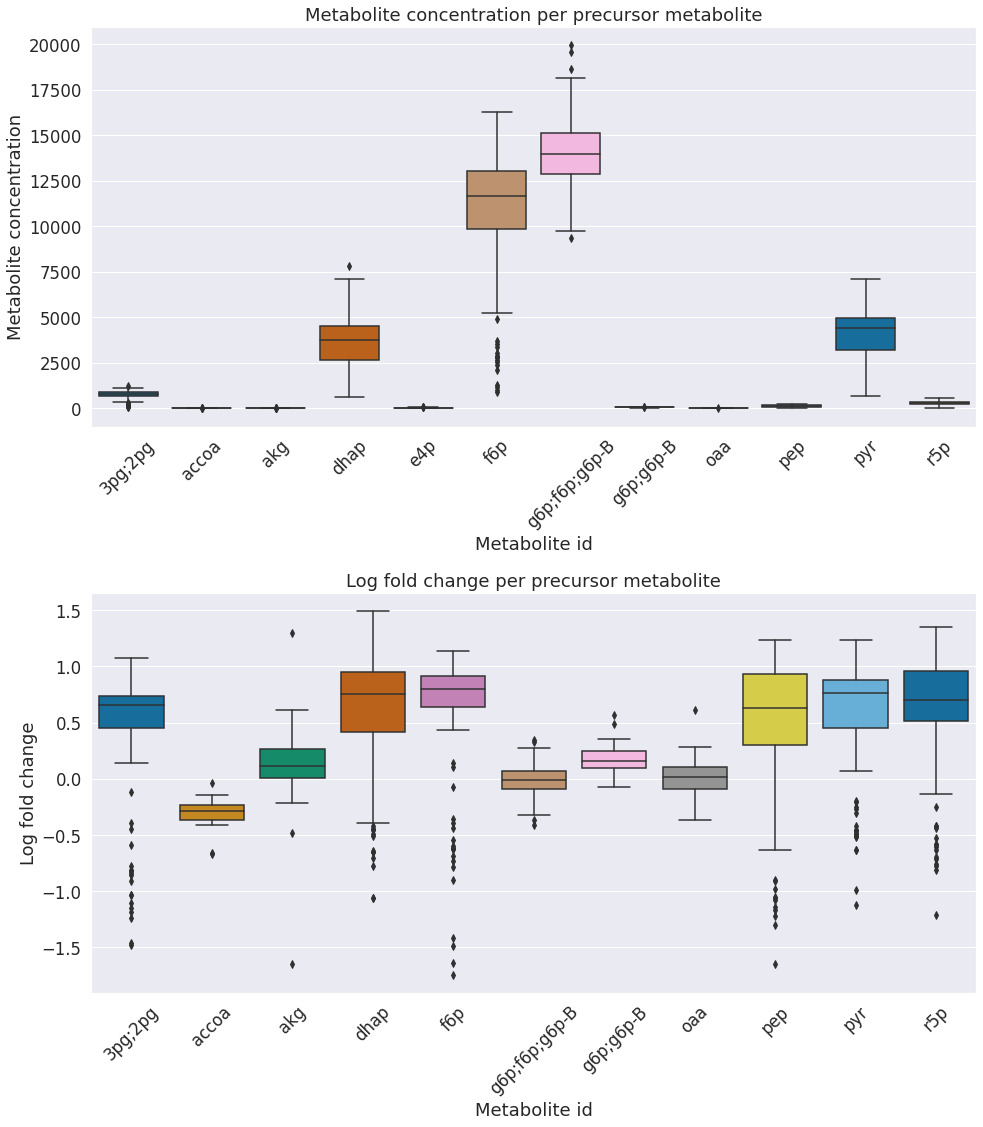

In [9]:
sns.set(font_scale=1.5)
fig, ((ax3, ax4)) = plt.subplots(nrows=2, ncols=1, figsize=(14, 16))

g3 = sns.boxplot(
    data=precursor_dataset_raw.y.reset_index().sort_values('metabolite_id'),
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax3,
    palette='colorblind',
)

g3.axes.set_xticklabels(g3.axes.get_xticklabels(), rotation=45)
g3.set(xlabel="Metabolite id", ylabel="Metabolite concentration", title="Metabolite concentration per precursor metabolite")

g4 = sns.boxplot(
    data=precursor_dataset.y.reset_index().sort_values('metabolite_id'),
    x='metabolite_id',
    y='metabolite_concentration',
    ax=ax4,
    palette='colorblind',
)

g4.axes.set_xticklabels(g4.axes.get_xticklabels(), rotation=45)
g4.set(xlabel="Metabolite id", ylabel="Log fold change", title="Log fold change per precursor metabolite")
plt.tight_layout()

plt.savefig('./images/explorative/boxplot_log_fold_transformation.svg')
plt.savefig('./images/explorative/boxplot_log_fold_transformation.png')

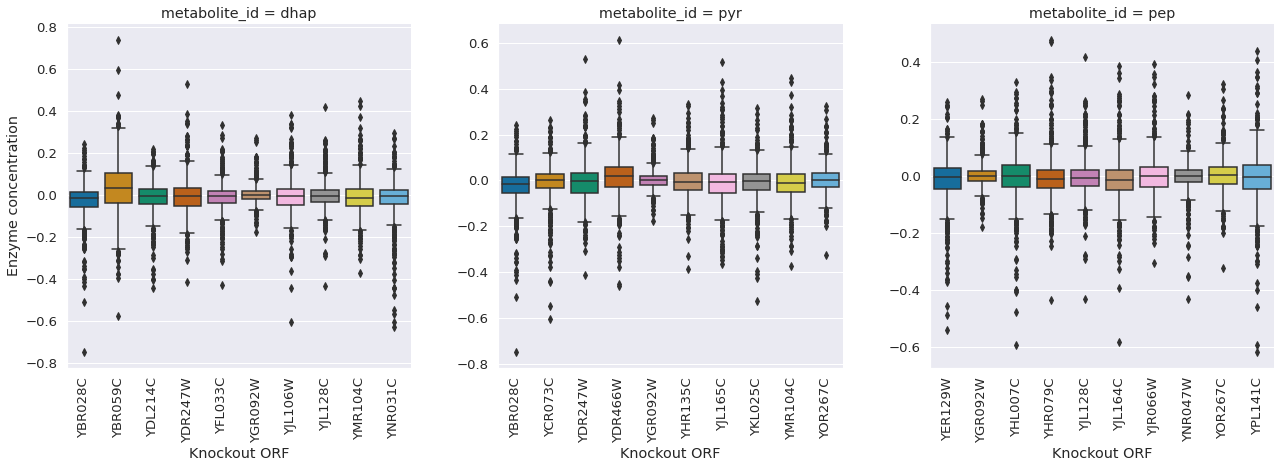

In [10]:
sns.set(font_scale=1.2)
_df_x = precursor_dataset.x[precursor_dataset.x.index.isin(['pep', 'pyr', 'dhap'], level=1)]
_df_y = precursor_dataset.y[_df_x.index].abs().sort_values(ascending=False).groupby('metabolite_id').head(10)
_df_x = _df_x.loc[_df_y.index]
_df = _df_x.T.stack([0, 1]).to_frame('enzyme_concentration').reset_index()

def mapper(*args, **kwargs):
    df = kwargs['data']
    sns.boxplot(
        data=df,
        y='enzyme_concentration',
        x='KO_ORF',
        palette='colorblind'
    )

g = sns.FacetGrid(
    _df, 
    col='metabolite_id', 
    col_wrap=10,
    sharex=False,
    sharey=False,
    height=6
)
g.map_dataframe(mapper)

for axes in g.axes.flatten():
    axes.set_xticklabels(axes.get_xticklabels(), rotation=90)

g.set_axis_labels(x_var="Knockout ORF", y_var="Enzyme concentration")

plt.savefig('./images/explorative/effect_of_knockout_on_enzyme_concentration.svg', bbox_inches="tight")
plt.savefig('./images/explorative/effect_of_knockout_on_enzyme_concentration.png', bbox_inches="tight")